## Peer-graded Assignment: Week 4: NLP Disaster Tweets Kaggle Mini-Project

In [1]:
# -----------------------------
#  Standard‑library imports
# -----------------------------
import os
import pickle
import random
import re
import string
import warnings

# -----------------------------
#  Third‑party imports
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Embedding,
    Bidirectional,
    SimpleRNN,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

# -----------------------------
#  NLTK resource downloads
# -----------------------------
nltk.download("stopwords")
nltk.download("wordnet")

# -----------------------------
#  Reproducibility settings
# -----------------------------
# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
#  Global configuration
# -----------------------------
warnings.filterwarnings("ignore")

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/devsxae/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/devsxae/nltk_data...


In [5]:
# =============================================================
# 2. Kaggle competition download utility (second snippet)
# =============================================================
"""Utility script to download and extract competition data from Kaggle."""

from pathlib import Path
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi


def download_competition_data(competition: str, out_dir: str):
    # Authenticate with Kaggle
    api = KaggleApi()
    api.authenticate()

    # Create output directory if it doesn't exist
    out_dir_path = Path(out_dir)
    out_dir_path.mkdir(parents=True, exist_ok=True)

    # Download all files for the competition as a zip into out_dir
    print(f"Downloading data for competition '{competition}' into '{out_dir_path}'...")
    api.competition_download_files(competition, path=str(out_dir_path), quiet=False)

    # The Kaggle API will save a file named '<competition>.zip' in out_dir
    zip_path = out_dir_path / f"{competition}.zip"

    # Unzip the downloaded dataset
    print(f"Extracting '{zip_path}'...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(out_dir_path)

    # Remove the zip file to save space
    zip_path.unlink()
    print("Done.")


if __name__ == "__main__":
    download_competition_data("nlp-getting-started", "nlp-getting-started")

100%|██████████| 593k/593k [00:00<00:00, 659MB/s]


Extracting 'nlp-getting-started/nlp-getting-started.zip'...
Done.


#### Brief Description of the Problem and Data

The main task in this competition is to create a machine learning model that can distinguish between tweets that are reporting disasters and those that are not. Individuals are often using Twitter (now X) to report emergencies in real time, making it a valuable resource for disaster relief and news agencies. However, to be able to use Twitter for emergancy warining, disaster relief organizations and news agencies need to be able to distinguis between tweets that report actual instead of metaphorical disasters. This can be difficult since the same words, such as 'ablaze' can have different meaning depending on the context. The aim in this assignment is to create a model that is able to make such distinctions.

##### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

In this section, we will ...
* provide a quantitative overview of the training and testing data.
* Verify that the data is sound and can be used in a Recurrent Neural Network (CNN) model
* Carry out text preprocessing and sequence preparation for model training

In [6]:
# Loading data
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test  = pd.read_csv('nlp-getting-started/test.csv')

In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


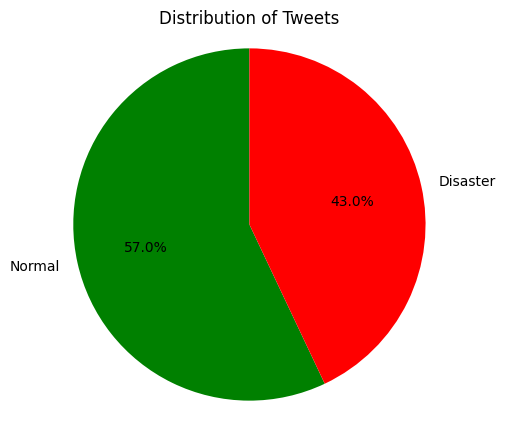

In [8]:
# Distribution of tweets
counts = df_train['target'].value_counts()
counts.index = ['Disaster' if i == 1 else 'Normal' for i in counts.index]

# Creating a pie chart
plt.figure(figsize=(5, 5))  # Set the size of the figure (optional)
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Distribution of Tweets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

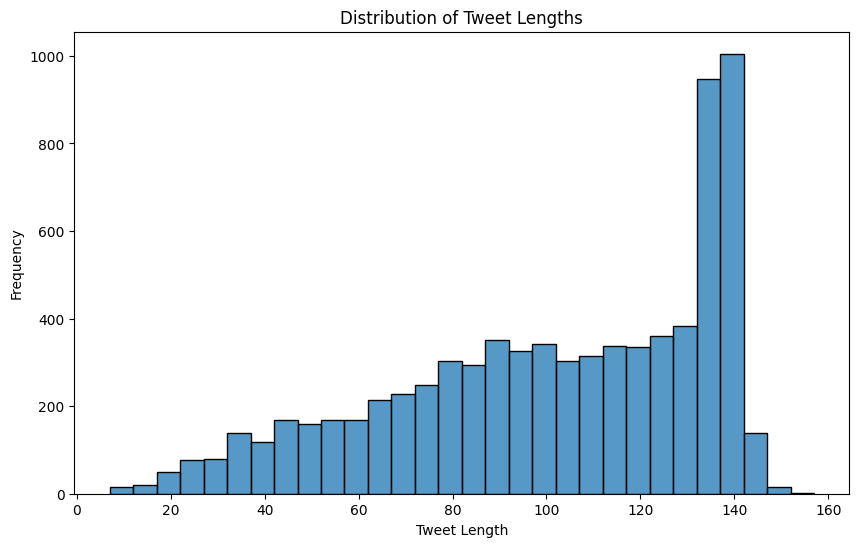

In [9]:
# Sample data loading
tweets = pd.read_csv('nlp-getting-started/train.csv')

# Basic statistics of tweet lengths
tweets['tweet_length'] = tweets['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(tweets['tweet_length'], bins=30, kde=False)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

###### Text Preprocessing and Sequence Preparation for Model Training

In [10]:
# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Precompiled regex patterns for efficiency
_non_word_pattern = re.compile(r"\W")
_multi_space_pattern = re.compile(r"\s+")


def clean_text(text):
    text = text.lower()  # Convert to lowercase
    # Remove all the special characters
    text = _non_word_pattern.sub(" ", text)
    # Replace multiple spaces with a single space
    text = _multi_space_pattern.sub(" ", text)
    # Lemmatization and stopword removal
    text = " ".join(
        [
            lemmatizer.lemmatize(word)
            for word in text.split()
            if word not in stop_words
        ]
    )
    return text


# Apply cleaning function
df_train["cleaned_text"] = df_train["text"].apply(clean_text)

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train["cleaned_text"],
    df_train["target"],
    test_size=0.2,
    random_state=42,
)

# Tokenizing text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)

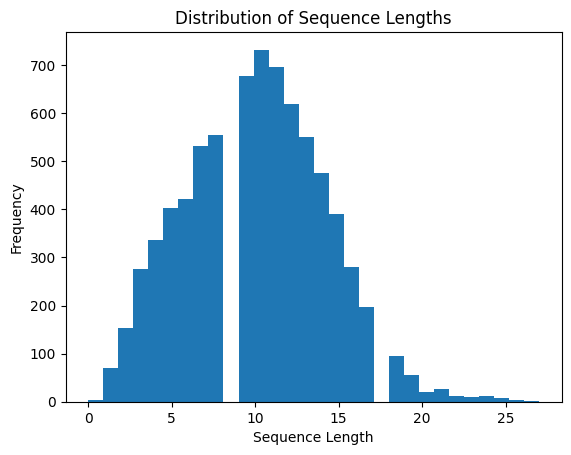

90th percentile: 15.0


In [11]:
# Analyzing the distribution of text lengths in terms of word count
sequence_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(df_train['cleaned_text'])]

# Plotting the distribution
plt.hist(sequence_lengths, bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determining a suitable `maxlen` based on percentile
import numpy as np
print("90th percentile:", np.percentile(sequence_lengths, 90))

In [12]:
# Padding sequences
X_train = pad_sequences(X_train, maxlen=15)
X_valid = pad_sequences(X_valid, maxlen=15)

Based on our investigations, we can conclude that:

* The dataset is balanced with about 43% real disaster tweets and 57% other tweets
* There is a large number of tweets that are 140 characters long, which for some time was the maximum allowed length. However, there are also a considerable number of tweets that are shorter.
* After we have removed stopwords and lemmatized the text, the most frequent tweets contain between 9-11 words (sequences)
* Since 90% of the tweets contained 15 or less words (sequences), we will set that as a maximum for our models.

All in all, this implies that there are good reasons to believe that the data should be suitable for an analysis using Ruccurrent Neural Networks.

In this section, we explore four RNN architectures:

    Vanilla (Basic): A straightforward recurrent layer that serves as our baseline.

    LSTM (Long Short-Term Memory): Adds gating mechanisms to capture long-range dependencies in sequential data.

    Bidirectional: Processes inputs forward and backward, enabling the network to incorporate both past and future context—especially valuable for NLP tasks.

    Deep (Stacked): Stacks multiple LSTM and dense layers to increase model capacity and representation power.

Our goal is to assess whether these architectural enhancements—adding LSTM cells, bidirectional flows, or extra layers—yield greater predictive accuracy compared to the basic RNN. We’ll reserve experimentation with optimizers and regularization methods for the next section, once we’ve identified the most promising architecture.

In [13]:
# Constants
max_words = 10000  # number of words to consider from the dataset
max_len   = 15  # sequences are padded/truncated to this length

In [14]:
def plot_training_history(history):
    # Get number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

In [15]:
def get_best_epoch_stats(model_names, histories):
    accuracies = []
    losses = []
    
    for model_name, history in zip(model_names, histories):
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = np.argmax(history.history['val_accuracy'])
        
        # Retrieve the accuracy and loss for the best epoch
        best_epoch_accuracy = history.history['val_accuracy'][best_epoch_index]
        best_epoch_loss = history.history['val_loss'][best_epoch_index]
        
        # Append the results to the respective lists
        accuracies.append(best_epoch_accuracy)
        losses.append(best_epoch_loss)
    
    return model_names, accuracies, losses
    

In [16]:
def plot_model_metrics(architectures, accuracies, losses):
    # Define colors
    accuracy_color = '#5BC0BE'
    loss_color = '#4C698D'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot accuracy
    axs[0].bar(architectures, accuracies, color=accuracy_color)
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_ylim([0, 1])

    # Adding the text labels on the bars
    for i in range(len(accuracies)):
        axs[0].text(i, accuracies[i] + 0.02, f'{accuracies[i]:.3f}', ha='center', va='bottom', color='black')

    # Plot loss
    axs[1].bar(architectures, losses, color=loss_color)
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_ylim([0, max(losses)+0.1])

    # Adding the text labels on the bars
    for i in range(len(losses)):
        axs[1].text(i, losses[i] + 0.02, f'{losses[i]:.2f}', ha='center', va='bottom', color='black')  # white text for better visibility on dark color

    # Layout adjustments
    plt.tight_layout()

    # Display the plot
    plt.show()


##### Vanilla RNN Architecture

In [17]:
# Define the model
model_vanilla = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), 
    SimpleRNN(64),  # Replacing LSTM with SimpleRNN
    Dense(1, activation='sigmoid')
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_vanilla.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_vanilla = model_vanilla.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_vanilla.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

2025-06-19 14:05:56.921191: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-06-19 14:05:56.921233: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-06-19 14:05:56.921244: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-06-19 14:05:56.921283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-19 14:05:56.921296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-06-19 14:05:58.159712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.5343 - loss: 0.6872 - val_accuracy: 0.6146 - val_loss: 0.6489
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.6546 - loss: 0.6338 - val_accuracy: 0.6527 - val_loss: 0.6220
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7154 - loss: 0.5922 - val_accuracy: 0.6980 - val_loss: 0.5924
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.7817 - loss: 0.5217 - val_accuracy: 0.7525 - val_loss: 0.5187
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8343 - loss: 0.4112 - val_accuracy: 0.7735 - val_loss: 0.4879
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8748 - loss: 0.3344 - val_accuracy: 0.7787 - val_loss: 0.4843
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.8954 - loss: 0.2830 - val_accuracy: 0.7800 - val_loss: 0.4890
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.9125 - loss: 0.2416 - val_accuracy: 0.7827 - val

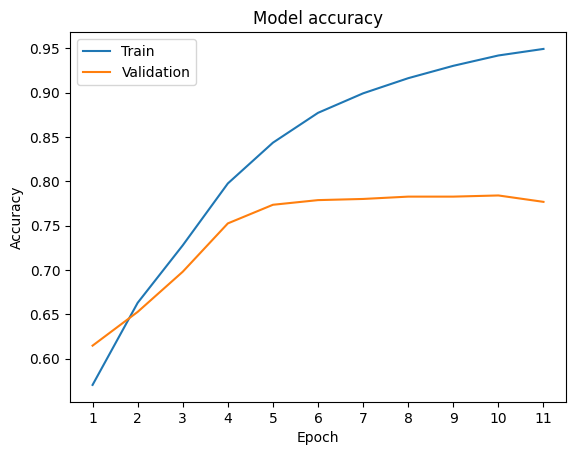

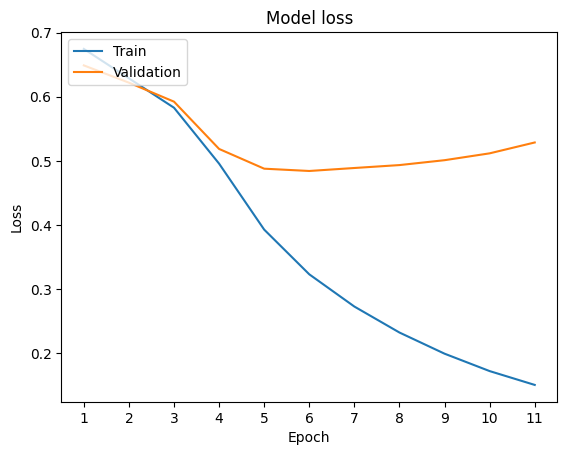

In [18]:
plot_training_history(history_vanilla)

##### LSTM (Long Short-Term Memory) Architecture

In [19]:
model_LSTM = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)),
    LSTM(64),  # Single LSTM layer
    Dense(1, activation='sigmoid')
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_LSTM.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_LSTM = model_LSTM.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_LSTM.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5649 - loss: 0.6882 - val_accuracy: 0.5896 - val_loss: 0.6639
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6048 - loss: 0.6585 - val_accuracy: 0.6172 - val_loss: 0.6380
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6507 - loss: 0.6365 - val_accuracy: 0.6573 - val_loss: 0.6219
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6821 - loss: 0.6166 - val_accuracy: 0.6848 - val_loss: 0.6041
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7115 - loss: 0.5901 - val_accuracy: 0.7144 - val_loss: 0.5778
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7592 - loss: 0.5451 - val_accuracy: 0.7577 - val_loss: 0.5249
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8224 - loss: 0.4505 - val_accuracy: 0.7853 - val_loss: 0.4669
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8538 - loss: 0.3532 - val_accuracy: 0.8050 - v

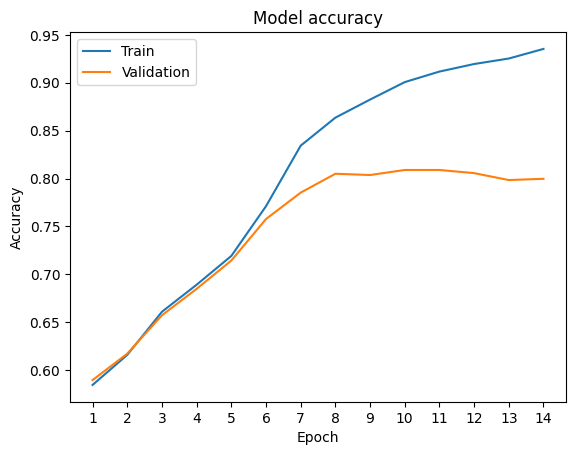

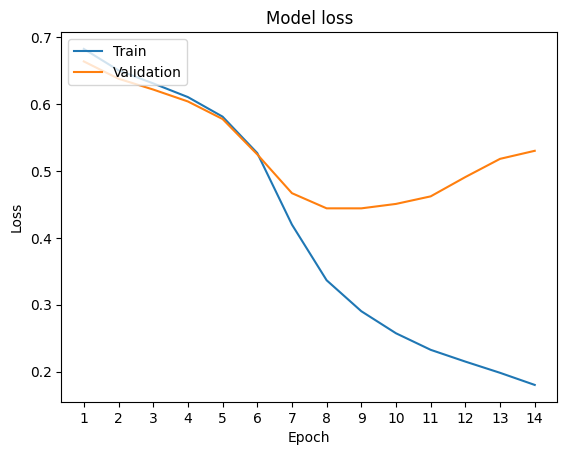

In [20]:
plot_training_history(history_LSTM)

##### Bidirectional LSTM RNN Architecture

In [21]:
# Model building
model_bidirect = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_bidirect.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_bidirect = model_bidirect.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_bidirect.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.5793 - loss: 0.6857 - val_accuracy: 0.5923 - val_loss: 0.6599
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.5993 - loss: 0.6573 - val_accuracy: 0.6139 - val_loss: 0.6382
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.6374 - loss: 0.6325 - val_accuracy: 0.6625 - val_loss: 0.6089
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7022 - loss: 0.5910 - val_accuracy: 0.7249 - val_loss: 0.5521
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7919 - loss: 0.4802 - val_accuracy: 0.7781 - val_loss: 0.4864
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.8695 - loss: 0.3226 - val_accuracy: 0.7768 - val_loss: 0.5201
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9024 - loss: 0.2558 - val_accuracy: 0.7787 - val_loss: 0.5584
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9223 - loss: 0.2065 - val_accuracy: 0.

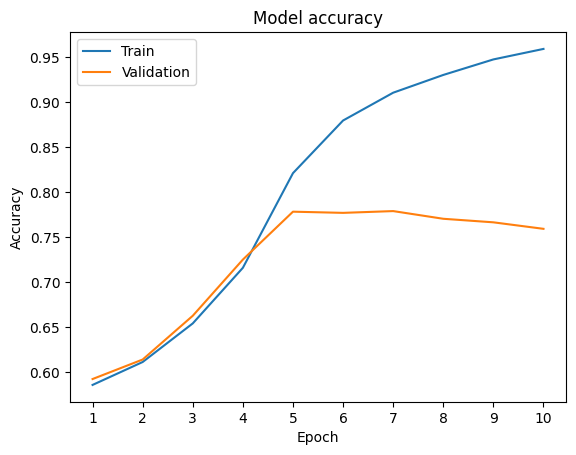

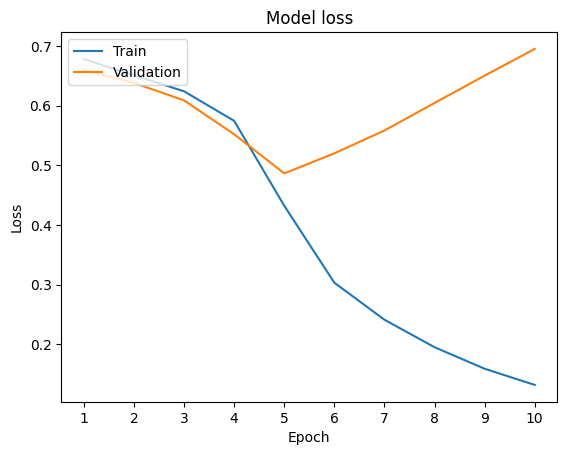

In [22]:
plot_training_history(history_bidirect)

##### Deep LSTM RNN Architecture

In [23]:
# Constructing the model
model_deep = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True),  # First LSTM layer, returns sequences to feed into next LSTM layer
    LSTM(64, return_sequences=False),  # Second LSTM layer, does not need to return sequences
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep = model_deep.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5696 - loss: 0.6857 - val_accuracy: 0.5758 - val_loss: 0.6550
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5957 - loss: 0.6544 - val_accuracy: 0.6310 - val_loss: 0.6378
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6628 - loss: 0.6313 - val_accuracy: 0.6907 - val_loss: 0.6095
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7432 - loss: 0.5767 - val_accuracy: 0.7846 - val_loss: 0.4974
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8398 - loss: 0.4034 - val_accuracy: 0.8037 - val_loss: 0.4500
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8808 - loss: 0.3063 - val_accuracy: 0.8142 - val_loss: 0.4642
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8992 - loss: 0.2596 - val_accuracy: 0.8063 - val_loss: 0.4838
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9142 - loss: 0.2210 - val_accuracy: 0.8024 - v

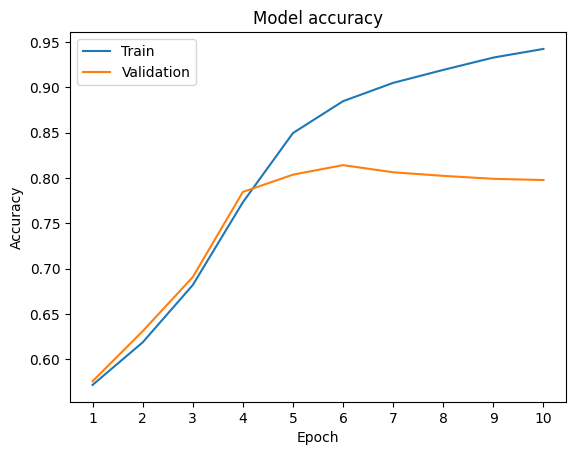

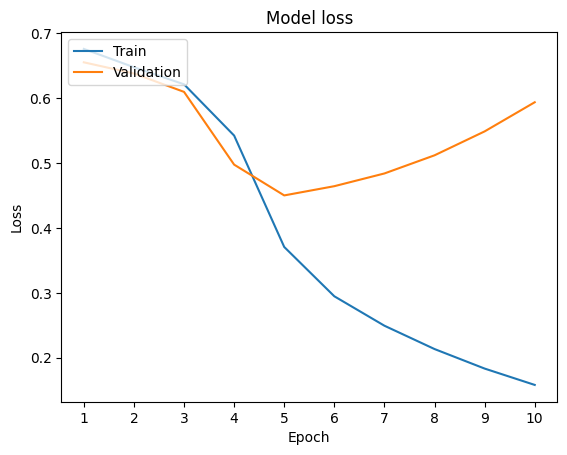

In [24]:
plot_training_history(history_deep)

<div style="background-color:#5BC0BE; padding: 15px; border-radius: 8px; border: 2px solid #0B132B; margin-top: 20px;">
    <h3 style="color: #0B132B; text-align: left; font-size: 22px; margin-top: 0;">Optional Utilities</h3>
</div>

In [25]:
# Plot models
#plot_model(model_vanilla, to_file='images/model_vanilla.png', show_shapes=True, show_layer_names=True)
#plot_model(model_LSTM, to_file='images/model_LSTM.png', show_shapes=True, show_layer_names=True)
#plot_model(model_bidirect, to_file='images/model_bidirect.png', show_shapes=True, show_layer_names=True)
#plot_model(model_deep, to_file='images/model_deep.png', show_shapes=True, show_layer_names=True)
#print("All images finished")

In [26]:
# Save models
#model_basic.save('models/model_vanilla.keras')
#model_deep.save('models/model_LSTM.keras')
#model_doubleConv.save('models/model_bidirect.keras')
#model_doubleDeep.save('models/model_deep.keras')

# Save history
#with open('history/model_vanilla.pkl', 'wb') as file:
#    pickle.dump(history_vanilla.history, file)

#with open('history/model_LSTM.pkl', 'wb') as file:
#    pickle.dump(history_LSTM.history, file)

#with open('history/model_bidirect.pkl', 'wb') as file:
#    pickle.dump(history_bidirect.history, file)

#with open('history/model_deep.pkl', 'wb') as file:
#    pickle.dump(history_deep.history, file)

In [27]:
# Load models
#model_basic = load_model('models/model_vanilla.keras')
#model_deep = load_model('models/model_LSTM.keras')
#model_doubleConv = load_model('models/model_bidirect.keras')
#model_doubleDeep = load_model('models/model_deep.keras')

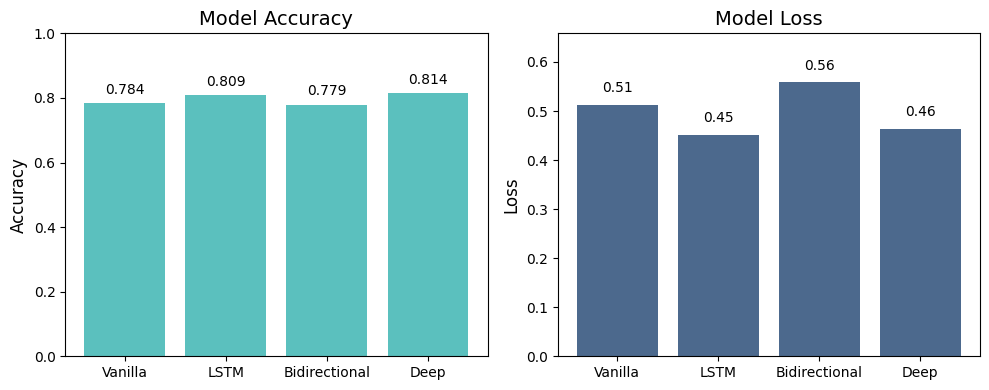

In [28]:
best = get_best_epoch_stats( ('Vanilla','LSTM', 'Bidirectional', 'Deep'), (history_vanilla, history_LSTM, history_bidirect, history_deep)  )
plot_model_metrics(*best)

From the comparison plots, both the LSTM and Deep architectures outperform the Vanilla and Bidirectional models. Between these two:

    The Deep model achieves the highest overall accuracy.

    The LSTM model yields the lowest validation loss.

Given the Deep model’s greater complexity and capacity for representational power, it offers more scope for improvement through regularization. Accordingly, we will adopt the Deep RNN architecture for the remainder of this project.

In the next phase, we’ll focus on two performance‐enhancement techniques:

    Optimizer Experiment: Compare our baseline optimizer with RMSprop to see if it accelerates convergence or improves final accuracy.

    L2 Regularization: Apply weight decay penalties of 0.001 and 0.0001 to assess their impact on generalization.

All experiments will be run on the selected Deep model, and we’ll track both accuracy and loss on training and validation sets to determine the best configuration.

In [29]:
# Constructing the model
model_deep_RMSprop = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True),  # First LSTM layer, returns sequences to feed into next LSTM layer
    LSTM(64, return_sequences=False),  # Second LSTM layer, does not need to return sequences
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Create a new RMSprop optimizer instance for this specific model
custom_rmsprop = RMSprop(learning_rate=0.0001)

# Compile the model
model_deep_RMSprop.compile(optimizer=custom_rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep_RMSprop = model_deep_RMSprop.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep_RMSprop.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5285 - loss: 0.6897 - val_accuracy: 0.5739 - val_loss: 0.6725
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5641 - loss: 0.6723 - val_accuracy: 0.5739 - val_loss: 0.6599
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5665 - loss: 0.6629 - val_accuracy: 0.5870 - val_loss: 0.6541
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5970 - loss: 0.6571 - val_accuracy: 0.6021 - val_loss: 0.6493
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6036 - loss: 0.6523 - val_accuracy: 0.6106 - val_loss: 0.6450
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6135 - loss: 0.6481 - val_accuracy: 0.6159 - val_loss: 0.6419
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6252 - loss: 0.6445 - val_accuracy: 0.6244 - val_loss: 0.6391
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6311 - loss: 0.6411 - val_accuracy: 0.6290 - v

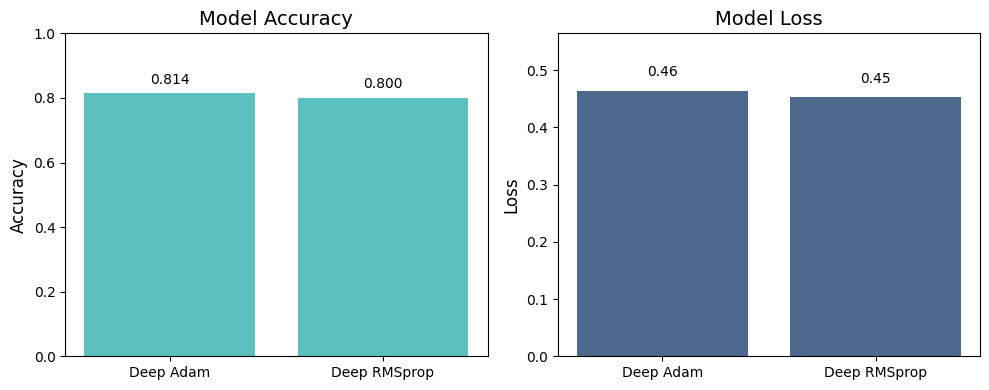

In [30]:
best = get_best_epoch_stats( ('Deep Adam', 'Deep RMSprop'), (history_deep, history_deep_RMSprop)  )
plot_model_metrics(*best)

In [31]:
# Set the L2 regularization factor
l2_reg = 0.0001  # This is an example value and can be adjusted based on the needs

# Constructing the model with L2 regularization
model_deep_l2_0001 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # First LSTM layer with L2 regularization
    LSTM(64, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Second LSTM layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Dense layer with L2 regularization
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Output layer with L2 regularization
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep_l2_0001.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep_l2_0001 = model_deep_l2_0001.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep_l2_0001.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5394 - loss: 0.7321 - val_accuracy: 0.5765 - val_loss: 0.7007
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5871 - loss: 0.6969 - val_accuracy: 0.6290 - val_loss: 0.6762
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6581 - loss: 0.6683 - val_accuracy: 0.6796 - val_loss: 0.6420
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7284 - loss: 0.6047 - val_accuracy: 0.7814 - val_loss: 0.5168
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8331 - loss: 0.4355 - val_accuracy: 0.8017 - val_loss: 0.4829
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8758 - loss: 0.3501 - val_accuracy: 0.8043 - val_loss: 0.4882
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8977 - loss: 0.3004 - val_accuracy: 0.8017 - val_loss: 0.5038
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9141 - loss: 0.2619 - val_accuracy: 0.8056 - v

In [32]:
# Set the L2 regularization factor
l2_reg = 0.001  # This is an example value and can be adjusted based on the needs

# Constructing the model with L2 regularization
model_deep_l2_001 = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)), # max_len
    LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # First LSTM layer with L2 regularization
    LSTM(64, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Second LSTM layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Dense layer with L2 regularization
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Output layer with L2 regularization
])

# Create a new Adam optimizer instance for this specific model
custom_adam = Adam(learning_rate=0.0001)

# Compile the model
model_deep_l2_001.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

# Train the model
history_deep_l2_001 = model_deep_l2_001.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

# Evaluate the model on the validation set
loss, accuracy = model_deep_l2_001.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5168 - loss: 1.1170 - val_accuracy: 0.5739 - val_loss: 1.0517
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5802 - loss: 1.0415 - val_accuracy: 0.6179 - val_loss: 0.9962
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6494 - loss: 0.9838 - val_accuracy: 0.6579 - val_loss: 0.9457
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7090 - loss: 0.9221 - val_accuracy: 0.7190 - val_loss: 0.8776
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7951 - loss: 0.8027 - val_accuracy: 0.8043 - val_loss: 0.7236
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8596 - loss: 0.6135 - val_accuracy: 0.8122 - val_loss: 0.7002
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8848 - loss: 0.5366 - val_accuracy: 0.8142 - val_loss: 0.6978
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9005 - loss: 0.4793 - val_accuracy: 0.8129 - v

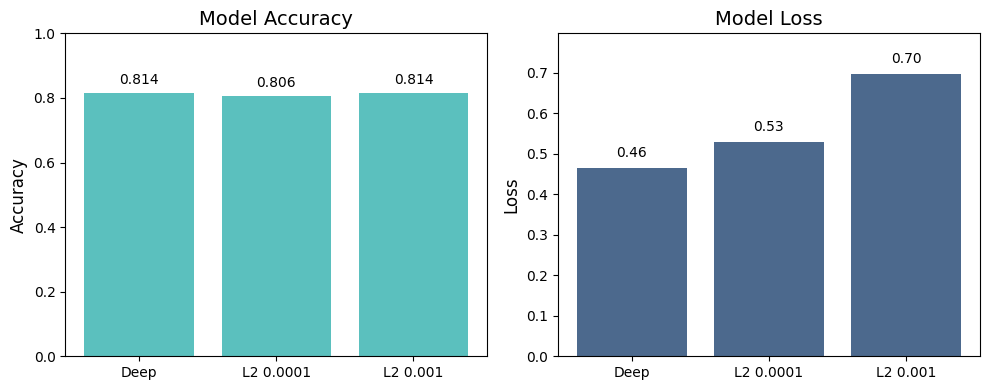

In [33]:
best = get_best_epoch_stats( ('Deep', 'L2 0.0001', 'L2 0.001'), (history_deep, history_deep_l2_0001, history_deep_l2_001)  )
plot_model_metrics(*best)

##### Conclusion

In this phase, we found that:

    Optimizer comparison: Switching from Adam to RMSprop did not boost accuracy—Adam remained marginally superior—although RMSprop achieved a slightly lower loss.

    L2 regularization: Introducing weight decay (0.001 and 0.0001) had negligible impact, suggesting our Deep model was not prone to overfitting.

    Model selection: The Deep RNN with the original Adam optimizer remains our best-performing configuration.

In [34]:
def predict_text(df, tokenizer, model, max_len):
    """
    Uses a pre-trained RNN model to predict the target based on text data in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the text data under 'text' column.
    tokenizer (Tokenizer): Pre-trained Keras Tokenizer used for training the model.
    model (tf.keras.Model): Pre-trained RNN model used for making predictions.
    max_len (int): Maximum length of the text sequences used for padding.

    Returns:
    pd.DataFrame: DataFrame with an additional column 'target' containing the predictions.
    """
    # Ensure text column is string type
    df['cleaned_text'] = df['cleaned_text'].astype(str)

    # Tokenize and pad the text data
    sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    # Predict using the RNN model
    predictions = model.predict(padded_sequences)

    # Convert predictions to binary (customize depending on your specific needs)
    df['target'] = (predictions > 0.5).astype(int)

    return df

In [35]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [36]:
df_test['cleaned_text'] = df_test['text'].apply(clean_text)
df_kaggle = predict_text(df_test, tokenizer, model_deep, max_len=15)
df_kaggle = df_kaggle[['id', 'target']]
df_kaggle

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [37]:
df_kaggle.to_csv('kaggle.csv', index=False)